In [1]:
#Uses naive bayes classification to separate root pixels from soil and condensation

%matplotlib widget
from plantcv import plantcv as pcv 
from plantcv import utils
from plantcv import learn
from plantcv.parallel import WorkflowInputs

# Training your model

One issue with minirhizotron data is condensation on the tubes, which sometimes looks like roots in simple threshold-based segmentation. We can use naive bayes instead to separate roots.  

First, you'll need to collect pixels from the 6 images in ./minirhizotron_images/
Aim for ~1000 pixels of each category (Root, Condensation, Soil).

Next, use `utils.tabulate_bayes_classes` to convert pixel file to the right format and `learn.naive_bayes_multiclass` to train a model based on your collected pixels.


In [2]:
# Format pixel file
# tabulate_bayes_classes takes an input file path and an output file path
utils.tabulate_bayes_classes("./Pixels_unformatted.txt", "./Pixels_formatted.txt")


# Train your model
# We will use multiclass since we have 3 categories. 
# Naive_bayes_multiclass takes the formatted pixel file as input and a file output name
learn.naive_bayes_multiclass("./Pixels_formatted.txt", "./Root_model.txt")

# Classify target image

The training function outputs a file that describes a probability density function for pixel categories and values. 
Using your trained model and an image of interest, classify pixels into your three categories. This step uses `pcv.naive_bayes_classifier` which takes an image and the training file as input. 

In [3]:
args = WorkflowInputs(images=["./minirhizotron_images/Silphium_08292023_DM_100dpi_T356merged.png"],
                      names="image1",
                      result="minirhizotron-results.csv",
                      outdir="img_output",
                      writeimg=False,
                      debug="plot")

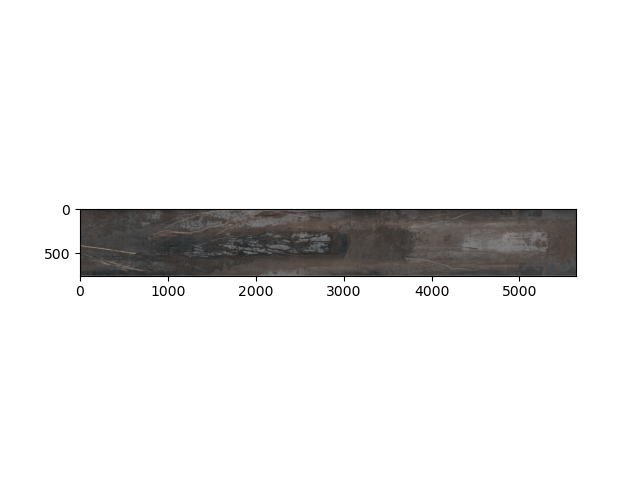

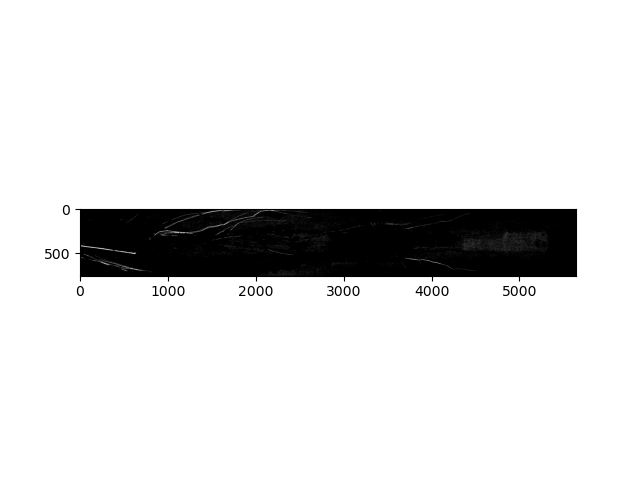

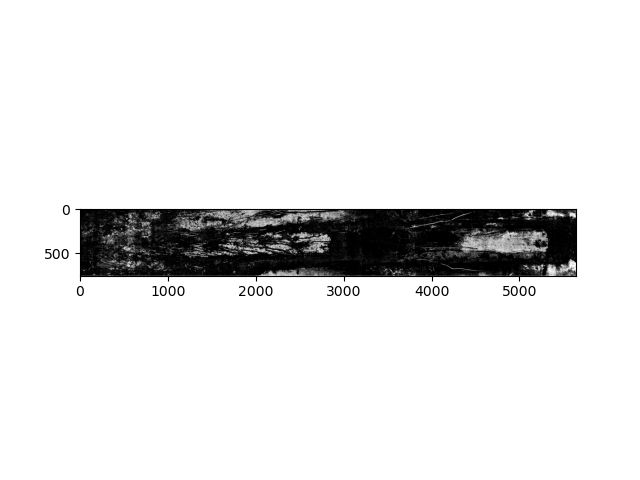

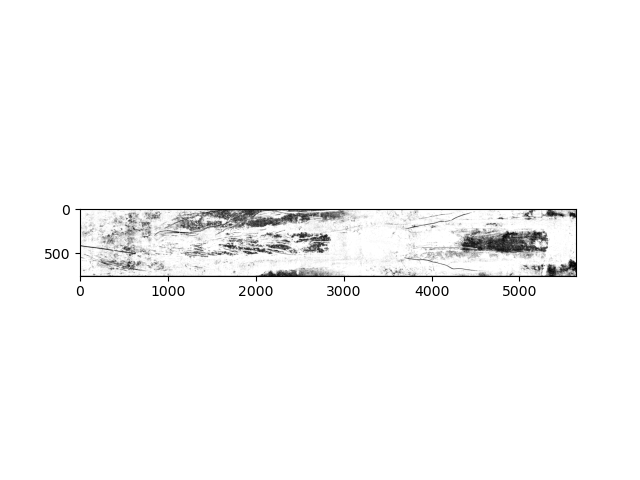

In [4]:
pcv.params.debug = args.debug

img, path, filename = pcv.readimage(filename=args.image1)
mask_list = pcv.naive_bayes_classifier(rgb_img=img, pdf_file="./Root_model.txt")

The debug images above are (in order): The RGB image, a binary mask with "Root" pixels in white, a binary mask with "Condensation" pixels in white, and a binary mask with "Soil" pixels in white. 

Because the minirhizotron images are so large, you can zoom in to parts where you can see roots by eye to assess the quality of the mask. 

The "Root" mask still has some background speckles, and the root edges are a little eroded, so we will use `fill` and `dilate` to improve the mask before analysis. 

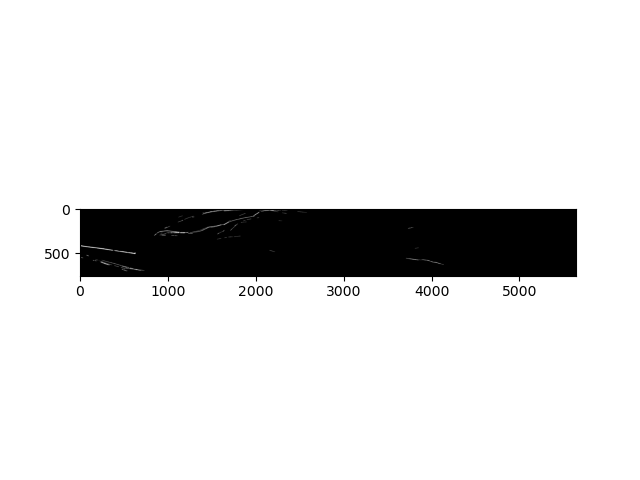

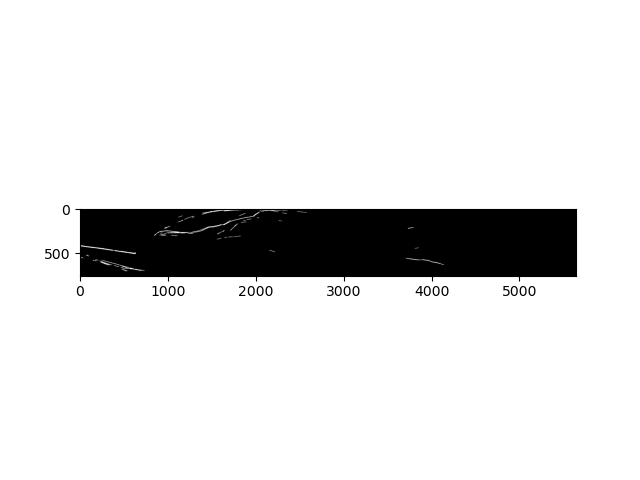

In [5]:
filled_mask = pcv.fill(bin_img=mask_list['Root'], size=50)

dilated_img = pcv.dilate(gray_img=filled_mask, ksize=3, i=1)


The resulting filled and dilated mask shows the roots much more cleanly.

# Analyze

Finally, we will use `analyze.distribution` to look at where the roots are distributed in the soil.
We can output the results of the analysis using 


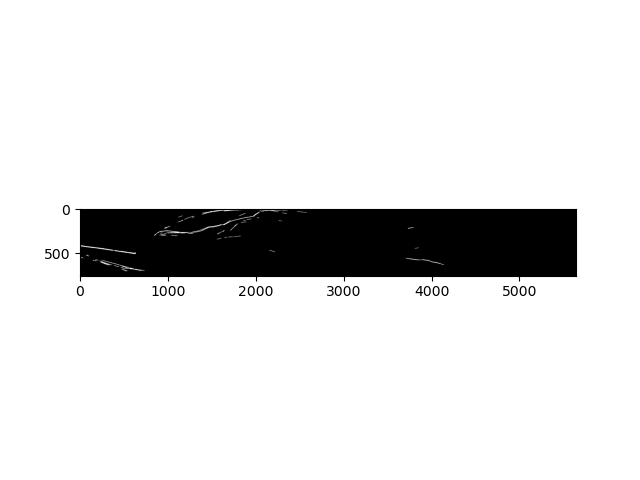

alt.FacetChart(...)

1302.4925045867453


In [6]:
pcv.outputs.clear()
pcv.plot_image(dilated_img)
pcv.analyze.distribution(labeled_mask=dilated_img, direction="across", bin_size=100)


print(pcv.outputs.observations['default_1']['x_distribution_mean']['value'])

pcv.outputs.save_results(filename=args.result, outformat='csv')